In [1]:
import npu
import numpy as np
from npu.build.appbuilder import AppBuilder
from npu.runtime import AppRunner
import pylab as plt
import scipy

In [2]:
M     = 2          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1024       # Number of windows of length M*P in input time stream
n_int = 10          # Number of time integrations on output data
n_points=M*P
dt=np.float32

In [3]:
def createKernel(kernel_name):
    kernel_path = f"./kernels/{kernel_name}.c"
    with open(kernel_path, 'r') as file:
        data = file.read()
    get_ipython().run_cell_magic('kernel', '', data)

def generateKernels():
    # Passtrough kernel
    createKernel("passthrough")
    dt = np.float32
    passthrough.ports[0].array = np.ndarray([1, n_points], dtype=dt) # uint16_t as placeholder of same size
    passthrough.ports[1].array = np.ndarray([1, n_points], dtype=dt)

    return [passthrough]

In [4]:
kernels = generateKernels()
passthrough

In [5]:
class SimpleApplication(AppBuilder):
    
    def __init__(self, kernel):
        self.kernel = kernel
        super().__init__()

    def callgraph(self, x_in:np.ndarray, x_out:np.ndarray):
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1]
        for row in range(rows):
            kernel_output = self.kernel(x_in[row], bytes_per_row)
            x_out[row] = kernel_output

In [6]:
app_builder = SimpleApplication(kernel=passthrough)

In [7]:
intput_img = np.zeros(shape=(1, n_points), dtype=dt)
output_img = np.zeros(shape=(1, n_points), dtype=dt)

app_builder.build(intput_img, output_img)

Using cached passthrough kernel object file...
Building the xclbin...
Successfully Building Application... SimpleApplication.xclbin & SimpleApplication.seq delivered


In [8]:
app_builder.metadata

{'application': 'SimpleApplication',
 'kernels': OrderedDict([('itbuffer_0',
               {'name': 'itbuffer_0',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': None,
                  'direction': 'in',
                  'name': 'ITin',
                  'ctype': None,
                  'shape': (1, 2048),
                  'dtype': 'float32'},
                 'ITout': {'c_dtype': None,
                  'direction': 'out',
                  'name': 'ITout',
                  'ctype': None,
                  'shape': (1, 2048),
                  'dtype': 'float32'}},
                'shape': (1, 2048),
                'dtype': 'float32'}),
              ('itbuffer_1',
               {'name': 'itbuffer_1',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin

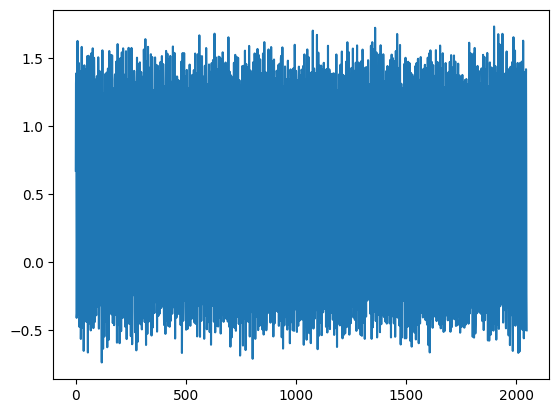

<Figure size 640x480 with 0 Axes>

In [9]:
noise = np.random.normal(loc=0.5, scale=0.1, size=n_points).astype(dt)
samples = np.arange(M*P)
freq    = 1
amp     = 1
cw_signal = (amp * np.sin(samples * freq))
data = noise + cw_signal
plt.plot(data)
plt.show()
plt.clf()

In [10]:
print(type(data))
print(data)

<class 'numpy.ndarray'>
[ 0.67372417  1.31637826  1.3891302  ...  0.8018404  -0.23441462
 -0.50183384]


In [11]:
app = AppRunner('SimpleApplication.xclbin')

In [12]:
# Allocate app input and output buffers to exchange data with NPU
input_image = app.allocate(shape=(1, n_points), dtype=dt)
output_image = app.allocate(shape=(1, n_points), dtype=dt)

In [13]:
# Load RGBA 720p image into input_image buffer
input_image[:] = data

In [14]:
# Pass input_image buffer to NPU
input_image.sync_to_npu()

In [15]:
# Run app on NPU
app.call(input_image, output_image)

In [16]:
# Get results from NPU via output_image buffer 
output_image.sync_from_npu()

Are the arrays are equal?: False


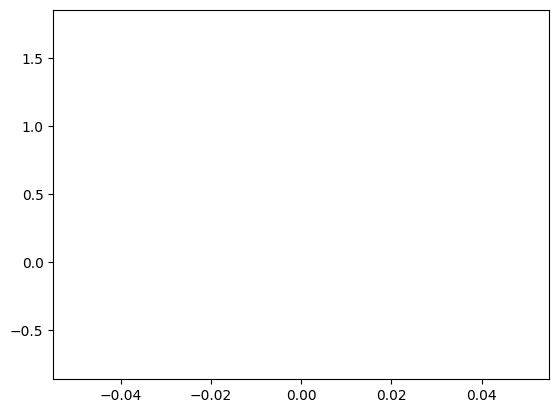

<Figure size 640x480 with 0 Axes>

In [17]:
# Compare the arrays for equality
print(f"Are the arrays are equal?: {np.array_equal(data, output_image)}")
plt.plot(output_image)
plt.show()
plt.clf()

In [18]:
print(type(output_image))
print(output_image)

<class 'npu.runtime.apprunner.PynqBuffer'>
[[ 0.6737242   1.3163782   1.3891302  ...  0.8018404  -0.23441462
  -0.50183386]]


In [19]:
gg = np.zeros(shape=(1, n_points), dtype=dt)
gg[:] = output_image
gg = gg[0]
print(type(gg))
print(gg.shape)
print(gg.dtype)
print(gg)

<class 'numpy.ndarray'>
(2048,)
float32
[ 0.6737242   1.3163782   1.3891302  ...  0.8018404  -0.23441462
 -0.50183386]


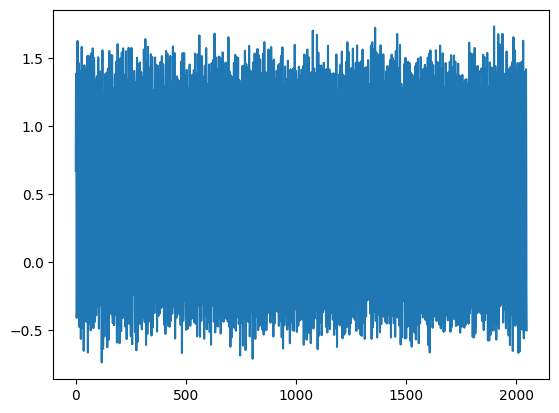

<Figure size 640x480 with 0 Axes>

In [29]:
plt.plot(gg)
plt.show()
plt.clf()

In [30]:
s = 0
for i in range(n_points):
    if data[i] != gg[i]:
        s += 1
print(s)

2047


<class 'numpy.ndarray'>
(2048,)
float64


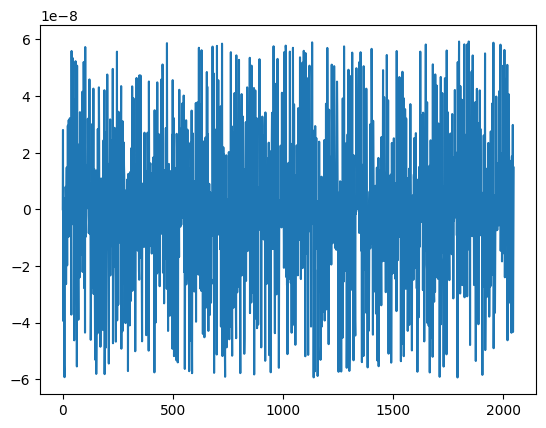

<Figure size 640x480 with 0 Axes>

In [31]:
diff = np.subtract(data, gg)
print(type(diff))
print(diff.shape)
print(diff.dtype)
plt.plot(diff)
plt.show()
plt.clf()

In [23]:
del app